This notebook demonstrates a pipeline combining BERT for document retrieval and GPT-2 for response generation. Here’s a breakdown of its functionality:

Load Models: BERT and GPT-2 models are loaded using the Hugging Face Transformers library.
Compute BERT Embeddings: The compute_bert_embeddings function computes embeddings for a list of documents using BERT. 

These embeddings are used to index the documents with FAISS.

FAISS Index: An index is created using FAISS to perform efficient similarity searches on document embeddings.

Query Embedding: The get_query_embedding function generates an embedding for a given query using BERT.

Document Retrieval: The retrieve_documents function uses FAISS to find and return the top-k most similar documents to the query.

Response Generation: The generate_response function combines the query with the retrieved documents and generates a response using GPT-2.

Example Output:

For the query "What are the symptoms of skin cancer?", the pipeline:

Retrieves relevant documents based on the query.

Generates a response by combining the query with the content of the retrieved documents and then processing it through GPT-2.

This approach leverages BERT's ability to understand and represent text for retrieval, and GPT-2's capability to generate coherent and contextually relevant responses.

In [16]:
!pip install faiss-gpu

# <div style="background-color: #2F4F4F; font-family: 'isha', serif; font-size: 36px; color: #00FFFF; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #00FFFF; box-shadow: 0 4px 10px rgba(47, 79, 79, 0.5);">Imports and Model Loading</div>

In [17]:
import torch
from transformers import BertTokenizer, BertModel, GPT2LMHeadModel, GPT2Tokenizer
import faiss
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# Load BERT and GPT-2 models
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained('bert-base-uncased')
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained('gpt2')
model_gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

# <div style="background-color: #2F4F4F; font-family: 'isha', serif; font-size: 36px; color: #00FFFF; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #00FFFF; box-shadow: 0 4px 10px rgba(47, 79, 79, 0.5);">Document Indexing</div>

In [18]:
# Sample documents for vector indexing
documents = [
    "info about skin cancer...",
    "treatment options for skin cancer...",
    "explaining symptoms of skin cancer..."
]

# Function to compute BERT embeddings for documents
def compute_bert_embeddings(texts, batch_size=8):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer_bert(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model_bert(**inputs)
        # Pooler output (CLS token) is used as the embedding
        batch_embeddings = outputs.pooler_output.cpu().numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

# Compute embeddings for the documents
embeddings = compute_bert_embeddings(documents)

# FAISS index creation (can switch to IndexIVFFlat for large datasets)
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(embeddings)

# <div style="background-color: #2F4F4F; font-family: 'isha', serif; font-size: 36px; color: #00FFFF; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #00FFFF; box-shadow: 0 4px 10px rgba(47, 79, 79, 0.5);">Query Embedding and Document Retrieval</div>

In [19]:
# Function to get embeddings for a query
def get_query_embedding(query):
    inputs = tokenizer_bert(query, return_tensors='pt', max_length=512, truncation=True)
    with torch.no_grad():
        embedding = model_bert(**inputs).pooler_output.squeeze().numpy()
    return embedding

# Retrieve top-k documents based on FAISS similarity search
def retrieve_documents(query, k=2):
    if len(documents) == 0:
        raise ValueError("No documents available for retrieval.")
    
    query_embedding = get_query_embedding(query)
    D, I = index.search(np.array([query_embedding]), k)
    
    if len(I[0]) == 0:
        raise ValueError("No documents found for the query.")
    
    return [documents[i] for i in I[0]]

# <div style="background-color: #2F4F4F; font-family: 'isha', serif; font-size: 36px; color: #00FFFF; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #00FFFF; box-shadow: 0 4px 10px rgba(47, 79, 79, 0.5);">Response Generation</div>

In [20]:
# Generate a response using GPT-2
def generate_response(query, retrieved_docs, max_length=200, temperature=0.7):
    augmented_query = query + " " + " ".join(retrieved_docs)
    
    inputs_gpt2 = tokenizer_gpt2(augmented_query, return_tensors='pt', max_length=512, truncation=True)
    with torch.no_grad():
        response_ids = model_gpt2.generate(
            inputs_gpt2['input_ids'],
            max_length=max_length,
            temperature=temperature,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            pad_token_id=tokenizer_gpt2.eos_token_id
        )
    
    return tokenizer_gpt2.decode(response_ids[0], skip_special_tokens=True)

# <div style="background-color: #2F4F4F; font-family: 'isha', serif; font-size: 36px; color: #00FFFF; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #00FFFF; box-shadow: 0 4px 10px rgba(47, 79, 79, 0.5);">Example Usage</div>

In [21]:
# Example usage
query = "What are the symptoms of skin cancer?"
retrieved_docs = retrieve_documents(query, k=2)
generated_response = generate_response(query, retrieved_docs)

print("Query:", query)
print("Retrieved Documents:")
for doc in retrieved_docs:
    print(f"- {doc}")
print("Generated Response:", generated_response)

Query: What are the symptoms of skin cancer?
Retrieved Documents:
- info about skin cancer...
- treatment options for skin cancer...
Generated Response: What are the symptoms of skin cancer? info about skin cancer... treatment options for skin cancer...

What is the diagnosis of melanoma?
.
,
 (1) The diagnosis is based on the presence of a tumor in the skin. (2) It is not a cancer of the melanocytes. The tumor is a benign tumor that is present in a small area of tissue. It may be present on a skin surface, or on an area that has been exposed to sunlight. If the tumor has not been present, it may not be a melanocytic tumor. A melanocyte is an organ that contains melanin. When the cells of an animal are exposed, they become melanocortin, which is what causes the cancer. In humans, melanomas are caused by a mutation in melanoprotein, a protein that binds to melanoblast cells. This mutation causes a change in how melanoblasts are formed. These cells are called melanogaster cells, and


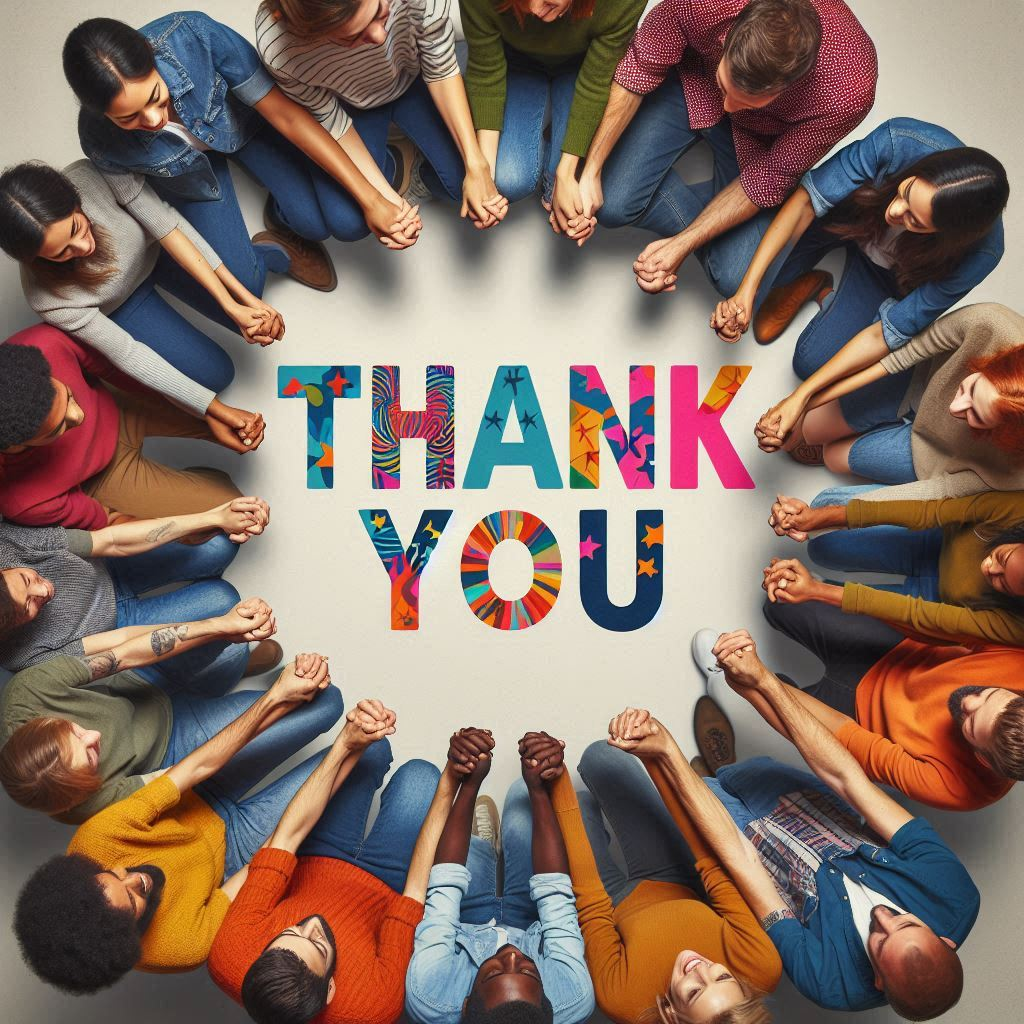